In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection done by Conditional Inference Trees and its Random Forest adaption

CIT uses p-value as one-a-split criterion instead of using homogeneity. The algorithm will pick the feature with the least p-value and will start splitting from it. Then it will keep going until it no longer finds statistically significant p-value or some other criteria have met such as minimum node size or max split. 

In [2]:
import sys
import numpy as np
import pandas as pd
import pickle

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, mean_absolute_error
from sklearn.preprocessing import QuantileTransformer, quantile_transform, PowerTransformer, power_transform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import PredictionErrorDisplay 
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import quantile_transform
from scipy import stats 


import matplotlib.pyplot as plt

sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.settings as s
import utils.utils_evaluation as e

s.init()
seed = s.seed


pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings('ignore')

transformation = True ##False
targets = ["Target_contentloss_euro", "Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[0]
# ruff check ./model_preprocessing/Feature_selection/utils_feature_selection.py --fix

c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

## Load R packages to process Conditional Random Forest in python
*Note 1: all needed R packages have to be previously loaded in R*

*Note 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*

In [3]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import rpy2.robjects.packages as rpackages


# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats_r = importr("stats")  # rename due to similar python package
# pandas.DataFrames to R dataframes 
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()


# get libraries for CRF processing, ctree_controls etc
partykit = importr('partykit')
party = importr('party')
caret = importr('caret') # package version >=
nestedcv = importr("nestedcv")
#stablelearner = importr('stablelearner')
ggplot2 = importr('ggplot2')


## input data

In [4]:
df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss_tueb.xlsx")
#df_candidates = pd.read_excel("../../../input_survey_data/input_data_businessreduction_tueb.xlsx")


#df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss.xlsx")
#df_candidates = pd.read_excel("../../../input_survey_data/input_data_businessreduction_tueb.xlsx")

# ### use only relative loss as target or only absolute loss as target
#df_candidates = df_candidates.drop(["Target_contentloss_euro", "shp_content_value_euro"], axis=1)
df_candidates = df_candidates.drop(["Target_relative_contentloss_euro"], axis=1)

df_candidates[target].describe()

count       382.000000
mean        915.749476
std       11673.198952
min           0.000000
25%           0.000000
50%           0.000000
75%          78.600000
max      224190.400000
Name: Target_contentloss_euro, dtype: float64

In [5]:
## TODO make this shorter

try:
    #if target=="Target_relative_contentloss_euro": 
    df_candidates = df_candidates.drop("floors", axis=1 )  # remove if still in ds due that it's used for shp_content_value and relative content loss
    df_candidates = df_candidates.drop("resilience_govern_careing_increases", axis=1)
    df_candidates = df_candidates.drop("buildingtype_moon", axis=1)  # remove due to 64 % missing values   
except:
    pass

df_candidates.shape


(397, 33)

In [6]:
print("Percentage of missing values per feature [%]\n", df_candidates.isna().mean().sort_values(ascending=False)[:15]  * 100) 
#df_candidates = df_candidates[df_candidates.columns[df_candidates.isna().mean() < 0.10]]  # drop feautres with more than 10% missing values
#print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))
## --> drops content values if threshold == 15%


Percentage of missing values per feature [%]
 elevation_building_height_cm           15.869018
shp_content_value_euro                 15.617128
resilience_govern_careing_increases    13.602015
shp_registered_capital_euro            11.838791
bage                                    6.801008
hh_monthly_income_cat                   6.045340
Target_contentloss_euro                 3.778338
inundation_duration_h                   2.267003
b_area                                  0.503778
water_depth_cm                          0.251889
emergency_measures.3                    0.000000
emergency_measures.1                    0.000000
contaminations_heavy                    0.000000
contaminations_light                    0.000000
contaminations.0                        0.000000
dtype: float64


### Test model performance without zero-loss records

In [7]:
print(f"Removing {df_candidates.loc[df_candidates[target]==0.0,:].shape[0]} zero loss records")
df_candidates = df_candidates.loc[df_candidates[target]!=0.0,:]

print(f"Keeping {df_candidates.shape} damage cases for model training and evaluation")

Removing 226 zero loss records
Keeping (171, 33) damage cases for model training and evaluation


### Test remove further features

In [8]:
df_candidates = df_candidates.drop([
        "contaminations_light", "contaminations_heavy", 
     ], axis=1
)
df_candidates.shape


(171, 31)

## Split Data

In [9]:
## remove records where target information is missing
#df_candidates = df_candidates[ ~df_candidates[f"{target}"].isna()]
#print(df_candidates.shape)

## Handle nan values in X and target
df_candidates = df_candidates.dropna()

X = df_candidates.drop(target, axis=1)
y = df_candidates[target]


# # TEST: replace nan with median of each variable
# for c in X.columns:
#    X[c].fillna(X[c].median(), inplace=True)

In [10]:
crf_ncv = nestedcv.nestcv_train(
    y=y, x=X,
    method="cforest",
    savePredictions="final",
    outer_train_predict=True,
    n_outer_folds=2,
    n_inner_folds=2,
    #tuneGrid=tg,
    #cv_cores=2,  # leads to random errors
    metric='MAE',#'RMSE',  # RMSE unit of target or use MAE due that more robust than RMSE further metrics options Rsquared, RMSE, MAE 
        # RMSE penalizes large gaps more harshly than MAE
    maximize=True,
    # #na_action =  stats.na_pass,
    controls = #party.cforest_control( 
        party.cforest_unbiased(
        # only mtry gets tuned by grid
        mtry=2,  # mtry=0 =Bagging without random input var sampling
        ntree = 100,  # didnt improved with 200 or 500 trees
        # mincriterion = 0.05,   # the value of the test statistic (for testtype == "Teststatistic"), or 1 - p-value (for other values of testtype) that must be exceeded in order to implement a split.
        #replace = False,
        #fraction = 0.632,   # fraction of number of observations to draw without replacement (only relevant if replace = FALSE).
    ),  # cforest_unbiased= subsampling without replacement repalce=False a
    trControl = caret.trainControl(
        method = "repeatedcv",  # "oob" - then no repeats are needed
        number = 10,   ## = K-folds
        repeats = 5,  # number of tried values for mtry
        #savePredictions = "final"  # saves predictions from optimal tuning parameters
    )
)
print(crf_ncv)
# without maximize: 2.405e+04   2.098e-03   5.734e+03   
# with maximize=True 

R[write to console]: Fitting final model using CV on whole data



R[write to console]: Performing 2-fold outer CV, using 1 core

R[write to console]: Duration: 26.14808 secs



$call
(function (y, x, method = "rf", filterFUN = NULL, filter_options = NULL, 
    weights = NULL, balance = NULL, balance_options = NULL, outer_method = c("cv", 
        "LOOCV"), n_outer_folds = 10, n_inner_folds = 10, outer_folds = NULL, 
    inner_folds = NULL, pass_outer_folds = FALSE, cv.cores = 1, 
    multicore_fork = (Sys.info()["sysname"] != "Windows"), metric = ifelse(is.factor(y), 
        "logLoss", "RMSE"), trControl = NULL, tuneGrid = NULL, 
    savePredictions = "final", outer_train_predict = FALSE, finalCV = TRUE, 
    na.option = "pass", verbose = TRUE, ...) 
{
    start <- Sys.time()
    nestcv.call <- match.call(expand.dots = TRUE)
    outer_method <- match.arg(outer_method)
    if (is.character(y)) 
        y <- factor(y)
    if (!is.null(balance) & is.numeric(y)) {
        stop("`balance` can only be used for classification")
    }
    ok <- checkxy(y, x, na.option, weights)
    y <- y[ok$r]
    x <- x[ok$r, ok$c]
    weights <- weights[ok$r]
    if (!is.null(bal

In [11]:
# fit = nestedcv.nestcv_glmnet(y, X,
#     family = "multinomial",
#     alpha = 1,
#     n_outer_folds = 3)
crf_ncv
#nestedcv.innercv_summary(crf_ncv)
#nestedcv.predSummary(crf_ncv)
#nestedcv.summary(crf_ncv)


R[write to console]: Fitting final model using CV on whole data



R[write to console]: Performing 2-fold outer CV, using 1 core

R[write to console]: Duration: 21.05331 secs



0,call,$call (fu...
1,output,...
2,outer_result,[[1]] [[1...
3,outer_method,['cv']
4,outer_folds,$Fold1 ...
5,dimx,[1] 90 30
6,xsub,...
7,y,[2.950000...
...,...,...
14,finalTune,mtry 3 30
15,summary,[2.433276...


In [12]:
## test nested CV 

base.set_seed(seed)
## CV method
fitControl = caret.trainControl(
    method = "repeatedcv",  # "oob" - then no repeats are needed
    number = 10,   ## = K-folds
    repeats = 5,  # number of tried values for mtry
    #savePredictions = "final"  # saves predictions from optimal tuning parameters
)

# robjects.r('''
#         r_grid <- function(verbose=FALSE) {
#             expand.grid(ntree=10)#         }     ''')
# f = robjects.globalenv['r_grid']
# createCfGrid = base.expand_grid(controls = party.cforest_control(mtry=3, ntree=200)) #qnorm() =90th percentile
# mincriterion=stats.qnorm(0.9) # = default
# " train() will generate the grid for you. If you want to specify ntree you just pass a controls object in as another argument to train but leave out mtry:""
# https://stackoverflow.com/questions/20337137/run-cforest-with-controls-cforest-unbiased-using-caret-package?rq=4


## CIT handles by default missing values in response, while CRF doesnt accept missing vlaues in response
base.set_seed(seed)

# tg = expand.grid(
#     lambda=exp(seq(log(2e-3) , log(1e0), length.out=100)),
#     alpha=seq(0.8, 1, 0.1))

crf_cv = caret.train(
        Formula(f'{target} ~ .'), 
        data = df_candidates,
        method = "cforest",
        metric='MAE',#'RMSE',  # RMSE unit of target or use MAE due that more robust than RMSE further metrics options Rsquared, RMSE, MAE 
        # RMSE penalizes large gaps more harshly than MAE
        maximize=True,
        #na_action =  stats.na_pass,
        controls = #party.cforest_control( 
            party.cforest_unbiased(
            # only mtry gets tuned by grid
            mtry=2,  # mtry=0 =Bagging without random input var sampling
            ntree = 100,  # didnt improved with 200 or 500 trees
           # mincriterion = 0.05,   # the value of the test statistic (for testtype == "Teststatistic"), or 1 - p-value (for other values of testtype) that must be exceeded in order to implement a split.
            #replace = False,
            #fraction = 0.632,   # fraction of number of observations to draw without replacement (only relevant if replace = FALSE).
        ),  # cforest_unbiased= subsampling without replacement repalce=False a
        trControl = fitControl,
        #tuneGrid = #params_grid, # createCfGrid
        #verbose = False
    )
print(crf_cv) # 5687.575

base.warnings()

#  2    12073.87  0.2206921  6275.344   # cforest_control
#  2    12117.59  0.2585249  6246.422   # unbiased version



Conditional Inference Random Forest 

90 samples
30 predictors

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 82, 80, 81, 82, 80, 82, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   2    12117.59  0.2585249  6246.422
  16    13133.54  0.3203579  6257.250
  30    13991.25  0.3413818  6335.243

MAE was used to select the optimal model using the largest value.
The final value used for the model was mtry = 30.



<rpy2.rinterface_lib.sexp.NULLType object at 0x000001D257860C00> [RTYPES.NILSXP]

In [13]:
## test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, 
    random_state=seed, shuffle=True
)

# normlaize via MinMaxScaler, transform X_train ,then use the fitted scaler for X_test
X_train, X_test = fs.normalize_X(X_train, X_test)

print("Training size", X_train.shape)
print("Test size", X_test.shape)

train = pd.concat([y_train.reset_index(), X_train], axis=1).drop("index", axis=1)
test = pd.concat([y_test.reset_index(), X_test], axis=1).drop("index", axis=1)

Training size (76, 30)
Test size (14, 30)


## Model fit

In [14]:
# ## target transformations to test
# train_log = train.copy()
# train_quantile = train.copy()
# train_boxcox = train.copy()
# train_sqrt = train.copy()

# train_log[target] = np.log(train[target])
# target_quantile = quantile_transform(np.array(train[target]).reshape(-1, 1), n_quantiles=100, 
#         output_distribution="normal",
#         random_state=seed, copy=True
#     ) # n_quantiles def=1000 or n_samples
# train_quantile[target] = pd.Series(target_quantile.reshape(-1, ))

# train_sqrt[target] = np.sqrt(train[target])
# train_boxcox[target] = stats.boxcox(np.array(train[target]).reshape(-1,)+0.0001)[0]



In [25]:
##  CV with gridSearch from R 
## Due that cforest is a R package it only accepts other R functions for tunning and cross validation  
## CIT handles by default missing values in response, while CRF doesnt accept missing vlaues in response

# ## Define the hyperparamters
## NOTE: cant define hyperparameter ranges for cforest, caret.train(method="cforest") is doing this by itself
## train() Doc: https://search.r-project.org/CRAN/refmans/caret/html/train.html

base.set_seed(seed)
## CV method
fitControl = caret.trainControl(
    method = "repeatedcv",  # "oob" - then no repeats are needed
    number = 10,   ## = K-folds
    repeats = 5,  # number of tried values for mtry
    #savePredictions = "final"  # saves predictions from optimal tuning parameters
    )

# robjects.r('''
#         r_grid <- function(verbose=FALSE) {
#             expand.grid(ntree=10)
#         }
#     ''')
# f = robjects.globalenv['r_grid']
# createCfGrid = base.expand_grid(controls = party.cforest_control(mtry=3, ntree=200)) #qnorm() =90th percentile
# mincriterion=stats.qnorm(0.9) # = default
# " train() will generate the grid for you. If you want to specify ntree you just pass a controls object in as another argument to train but leave out mtry:""
# https://stackoverflow.com/questions/20337137/run-cforest-with-controls-cforest-unbiased-using-caret-package?rq=4

 
## CIT handles by default missing values in response, while CRF doesnt accept missing vlaues in response
# base.set_seed(seed)
# crf_cv = caret.train(
#         Formula(f'{target} ~ .'), 
#         data = train,
#         method = "cforest",
#         metric='MAE',#'RMSE',  # RMSE unit of target or use MAE due that more robust than RMSE further metrics options Rsquared, RMSE, MAE 
#         # RMSE penalizes large gaps more harshly than MAE
#         maximize=True,
#         #na_action =  stats.na_pass,
#         controls = #party.cforest_control( 
#             party.cforest_unbiased(
#             # only mtry gets tuned by grid
#             mtry=2,  # mtry=0 =Bagging without random input var sampling
#             ntree = 100,  # didnt improved with 200 or 500 trees
#            # mincriterion = 0.05,   # the value of the test statistic (for testtype == "Teststatistic"), or 1 - p-value (for other values of testtype) that must be exceeded in order to implement a split.
#             #replace = False,
#             #fraction = 0.632,   # fraction of number of observations to draw without replacement (only relevant if replace = FALSE).
#         ),  # cforest_unbiased= subsampling without replacement repalce=False a
#         trControl = fitControl,
        #tuneGrid = #params_grid, # createCfGrid
        #verbose = False
#    )

#base.set_seed(seed)
crf_cv = party.cforest(Formula(f'{target} ~ .'),  
    data=train,
    # data=pd.concat(
    #         [y.reset_index(), pd.DataFrame(X, columns=X_unscaled.columns)], 
    #         axis=1,
    #         ).drop("index", axis=1),
    #weights=1,
    control= party.cforest_control(mtry=2, ntree=300)
    #control= party.cforest_unbiased(mtry=best_hyperparameters.mtry, ntree=300)
    #control = partykit.ctree_control(mincriterion = 0.8)
)

print(crf_cv) # 5687.575

base.warnings()

# models_trained = {}         # incl no transformation
# for idx, train_ds in enumerate([train, train_quantile, train_boxcox, train_sqrt, train_log]):
# #for train_ds in [{train: "no transformation"}, {train_log:"natural log"}, {train_quantile: "quantile"}, {train_boxcox:"box-cox"}, {train_sqrt:"sqrt"}]:
#     transf_type = ["no", "quantile", "boxcox", "sqrt", "natural-log"][idx]
# models_trained[f"cit_{transf_type}_cv"] = 
# m = caret.train(
#         Formula(f'{target} ~ .'), 
#         data = train,
#         method = "cforest",
#         metric='MAE',#'RMSE',  # RMSE unit of target or use MAE due that more robust than RMSE further metrics options Rsquared, RMSE, MAE 
#         # RMSE penalizes large gaps more harshly than MAE
#         #maximize=True,
#         #na_action =  stats_r.na_pass,
#         controls = party.cforest_control( 
#             #party.cforest_unbiased(
#             # only mtry gets tuned by grid
#             mtry=2,  # mtry=0 =Bagging without random input var sampling
#             ntree = 100,  # didnt improved with 200 or 500 trees
#            # mincriterion = 0.05,   # the value of the test statistic (for testtype == "Teststatistic"), or 1 - p-value (for other values of testtype) that must be exceeded in order to implement a split.
#             replace = False,
#             #fraction = 0.632,   # fraction of number of observations to draw without replacement (only relevant if replace = FALSE).
#         ),  # cforest_unbiased= subsampling without replacement repalce=False a
#         trControl = fitControl,
#         #tuneGrid = #params_grid, # createCfGrid
#         #verbose = False
#     )


	 Random Forest using Conditional Inference Trees

Number of trees:  300 

Response:  Target_contentloss_euro 
Inputs:  inundation_duration_h, water_depth_cm, contaminations.0, flowvelocity, emergency_measures.1, emergency_measures.2, emergency_measures.3, emergency_measures.4, emergency_measures.7, emergency_measures.8, overall_problem_house, protect_valuables_impl, water_barriers_impl, pumping_equipment_impl, elevation_building_impl, resistant_material_building_impl, electricity_higher_impl, flood_protections_impl, flood_experience, elevation_building_height_cm, bage, b_area, hh_monthly_income_cat, shp_owner, shp_sector, shp_employees, shp_avgmonthly_sale_cat, resilience_govern_careing_increases, shp_content_value_euro, shp_registered_capital_euro 
Number of observations:  76 




<rpy2.rinterface_lib.sexp.NULLType object at 0x000001D257860C00> [RTYPES.NILSXP]

### Test conditional permutation importance (discussed by Debeer & Stobl 2020)
Replace party::varimp() by more stable (in regard to FI score for multiple repeats) and computational faster permimp:permimp()

In [19]:
permimp = importr("permimp")

In [28]:
print(train.shape)
print(test.shape)

varimp = party.varimp(crf_cv, conditional=False)  # old FI apporach (probably also based on permutation)
#party.varimp(crf_cv, conditional = True )
fi = permimp.permimp(crf_cv, conditional=True, progressBar=False)
# Error in permimp.default(list(method = "cforest", modelInfo = list(label = "Conditional Inference Random Forest",  : 
#   The permimp functions only works for random forest objects from the party- and randomForest-packages

(76, 31)
(14, 31)


In [34]:
fi#[0]

0,values,[-1.07569...
1,perTree,...
2,type,['Conditi...
3,info,$threshol...


In [27]:
df_importance = pd.DataFrame(
            {f"{model_name}_importances" : fi[0]},
            index=X_unscaled.columns.to_list(),
        ) 


0,values,[-1.63776...
1,perTree,...
2,type,['Conditi...
3,info,$threshol...


R[write to console]: Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'object' in selecting a method for function 'show': could not find function "train.formula"

R[write to console]: Error in train.formula(form = Target_contentloss_euro ~ ., data = list( : 
  could not find function "train.formula"



(76, 31)
(14, 31)


RRuntimeError: Error in train.formula(form = Target_contentloss_euro ~ ., data = list( : 
  could not find function "train.formula"


<rpy2.robjects.vectors.ListVector object at 0x0000021E477FF580> [RTYPES.VECSXP]
R classes: ('train', 'train.formula')
[StrSexpVe..., ListSexpV..., StrSexpVe..., ListSexpV..., ..., BoolSexpV..., LangSexpV..., StrSexpVe..., ListSexpV...]
  method: <class 'numpy.ndarray'>
  array(['cforest'], dtype='<U7')
<rpy2.robjects.vectors.ListVector object at 0x0000021E477FF580> [RTYPES.VECSXP]
R classes: ('train', 'train.formula')
[StrSexpVe..., ListSexpV..., StrSexpVe..., ListSexpV..., ..., BoolSexpV..., LangSexpV..., StrSexpVe..., ListSexpV...]
  modelType: <class 'numpy.ndarray'>
  array(['Regression'], dtype='<U10')
<rpy2.robjects.vectors.ListVector object at 0x0000021E477FF580> [RTYPES.VECSXP]
R classes: ('train', 'train.formula')
[StrSexpVe..., ListSexpV..., StrSexpVe..., ListSexpV..., ..., BoolSexpV..., LangSexpV..., StrSexpVe..., ListSexpV...]
...
  bestTune: <class 'rpy2.robjects.vectors.BoolVector'>
  <rpy2.robjects.vectors.BoolVector object at 0x0000021E5E1303C0> [RTYPES.LGLSXP]
R classe

## Empirical median ~ predicted median

And further statitics compared to their empirical coutnerpart.
-  mean /variance / std  compared to empirical distribution

In [32]:
print("CIT: ", target)
print(X_test.shape)
print("y_test median:", np.median(y_test))
print("y_test mean:", np.mean(y_test))

for model_name, model_cv in models_trained.items():

    model_name = model_name.split("_")[1]
    print(model_name)
    y_pred = stats_r.predict(model_cv, newdata=X_test)#, OOB=True, type="response") #  type = "prob" # conditional class probabilities extractPrediction(
    print(np.median(y_pred))
    print(stats.describe(y_pred))
# for model_name, model_cv in models_trained.items():
#     print(model_name)
#     print(stats.describe(
    #e.empirical_vs_predicted(
    #    X_test, y_test,
    #    models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
    #)

## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


CIT:  Target_contentloss_euro
(14, 30)
y_test median: 96.85
y_test mean: 271.9642857142857
no
973.9624431694617
DescribeResult(nobs=14, minmax=(134.88039844019926, 16844.30185853222), mean=3559.783320559504, variance=33453257.45741129, skewness=1.8304053171834829, kurtosis=1.6676565896737214)
quantile
-0.05326385050003997
DescribeResult(nobs=14, minmax=(-0.1725587024442954, 0.2574443967911894), mean=-0.027031089936802522, variance=0.017924055365391597, skewness=0.765807131297393, kurtosis=-0.42347996162618795)
boxcox
2.985739564048908
DescribeResult(nobs=14, minmax=(2.919697891048595, 3.0823515467601386), mean=2.9950477139838716, variance=0.0024643930358130553, skewness=0.2526952352506137, kurtosis=-0.9999098489908715)
sqrt
24.64957400923098
DescribeResult(nobs=14, minmax=(21.429810382708407, 29.442191107500317), mean=24.757678642247807, variance=5.650421846739868, skewness=0.7065185399242351, kurtosis=-0.06593704909733678)
natural-log
5.176853487041242
DescribeResult(nobs=14, minmax=(

In [68]:
# evalution results of the three tested models during CV and tunning
fs.r_models_cv_results(crf_cv)
#models_trained.keys()

NameError: name 'cit_no_cv' is not defined

In [62]:
## store trained model for evaluation
filename = f'./models_trained/crf_{target}'
pickle.dump(model_log, open(filename, 'wb'))


NameError: name 'model_log' is not defined

In [101]:
## get best model

#print(crf_cv.names)#$param
best_hyperparameters = fs.r_best_hyperparamters(crf_cv)
best_hyperparameters = fs.r_dataframe_to_pandas(best_hyperparameters)
print(best_hyperparameters)

   mtry
1   2.0


In [102]:
## refit model with best hyperparamters
#cit_model = partykit.ctree(Formula(f'{target} ~ .'),  
crf_model = party.cforest(Formula(f'{target} ~ .'),  
                                data=train,
                                #weights=1,
                                #control= party.cforest_control(mtry=best_hyperparameters.mtry, ntree=300)
                                control= party.cforest_unbiased(mtry=best_hyperparameters.mtry, ntree=300)
                                #control = partykit.ctree_control(mincriterion = 0.8)
                          )
print(crf_model)


	 Random Forest using Conditional Inference Trees

Number of trees:  300 

Response:  Target_contentloss_euro 
Inputs:  inundation_duration_h, water_depth_cm, contaminations.0, flowvelocity, emergency_measures.1, emergency_measures.2, emergency_measures.3, emergency_measures.4, emergency_measures.6, emergency_measures.7, emergency_measures.8, overall_problem_house, protect_valuables_impl, water_barriers_impl, pumping_equipment_impl, elevation_building_impl, resistant_material_building_impl, electricity_higher_impl, flood_protections_impl, flood_experience, elevation_rel2surrounding_cat, bage, b_area, hh_monthly_income_cat, shp_owner, shp_sector, shp_employees, shp_avgmonthly_sale_cat, contaminations_heavy 
Number of observations:  118 




## Model evaluation

In [103]:
crf_model_eval = pickle.load(open(f"./models_trained/crf_{target}", 'rb'))

#crf_model_eval = pickle.load(open(f"./models_trained/crf_{target}", 'rb'))
type(crf_model_eval)


rpy2.robjects.vectors.ListVector

In [104]:
## Predict

print(target)

y_pred = stats_r.predict(crf_model_eval, newdata=X_test)#, OOB=True, type="response") #  type = "prob" # conditional class probabilities extractPrediction(
y_pred  = base.round(y_pred)

## get back to python dtypes
y_pred = np.array(y_pred)
y_test = np.array(y_test)

## print evaluation report + check for overfitting 
y_pred_train = np.round(stats_r.predict(crf_model_eval, newdata=X_train), 1)#.reshape(-1)
print("\nTraining set")
e.evaluation_report(y_train, y_pred_train)

print("\nTesting set")
e.evaluation_report(y_test, y_pred)  # 1590, 1306.9

Target_contentloss_euro



Training set
Model Performance:
        Root Mean Square Error: 19855.52
        Normalized Root Mean Square Error: 14.67
        Mean Absolute Error: 4095.58
        Mean Bias Error: 38.88
        R²-Score: 0.075
    

Testing set
Model Performance:
        Root Mean Square Error: 8600.8
        Normalized Root Mean Square Error: 9.82
        Mean Absolute Error: 3933.96
        Mean Bias Error: 548.47
        R²-Score: 0.013
    


,mse,rmse,nrmse,mae,mbe,r2
0,73973764.8,8600.800242,9.820836,3933.957143,548.471429,0.012932


## Feature importance

In [33]:
## Code snippet from Danielas CRF script and from https://cran.r-project.org/web/packages/stablelearner/vignettes/forests.html

## Calculate variance importance based on selection frequency
# varimp = party.varimp(model, measures=["freq"])
# varimp_df = pd.DataFrame({'Variable': varimp.names, 'Importance': varimp})
## Sort the variable importance in descending order
# varimp_df = varimp_df.sort_values(by='freq', ascending=False)
## Plot the variance importance
# varimp_df.plot(kind='bar', x='term', y='freq', figsize=(10, 6))

# Extract variable importance values from the model
varimp = party.varimp(model_sqrt, conditional = True )  # compute conditional variable importance scores
# t = caret.varImp(crf_model)#, conditional=True) # caret derives FI a bit differently than party package
# pd.DataFrame({"names":X.columns.to_list(), "importances":pd.Series(t)[0]}).sort_values("importances", ascending=False).head(5)



NameError: name 'model_sqrt' is not defined

In [ ]:
## get best model from model_list:

for model_name, model_cv in models_trained.items():


In [ ]:
varimp

array([-5.19997089e+05,  2.23055806e+05,  0.00000000e+00,  3.97822201e+05,
        1.23512119e+04, -6.12748497e+04, -3.82051254e+04, -3.18881921e+05,
        7.70345205e+04,  1.45679200e+05,  0.00000000e+00, -1.39186059e+02,
       -4.24174029e+05,  2.75498702e+05, -2.27007553e+03, -1.46943839e+05,
       -3.19491218e+03, -5.40854200e+04,  0.00000000e+00,  1.05465621e+05,
        2.94141327e+04, -2.34927585e+05, -4.95047254e+04,  1.77174178e+05,
        7.06148940e+03, -1.99461282e+05,  3.35327042e+05,  9.28430465e+04,
       -5.73933234e+01])

In [ ]:
y_train.shape

(118,)

In [ ]:
# # ## Feature importance 


df_importance = pd.DataFrame({
    "name" : X_train.columns.to_list(),
    "importances" : varimp,
     }) 
df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
df_importance.head(5)


,name,importances
3,flowvelocity,397822.200668
26,shp_employees,335327.041844
13,water_barriers_impl,275498.701596
1,water_depth_cm,223055.805529
23,hh_monthly_income_cat,177174.178024


In [ ]:
## define threshold according to Hilpert 2020: "The rule of thumb is to take the absolute minimum value as a cutoff point."" 
fi_threshold = np.abs(np.min(varimp))
fi_threshold
print(fi_threshold)

## this is to high set to fi_threshold = fi_threshold /10
fi_threshold = fi_threshold # / 5
print(fi_threshold)

519997.0891648732
519997.0891648732


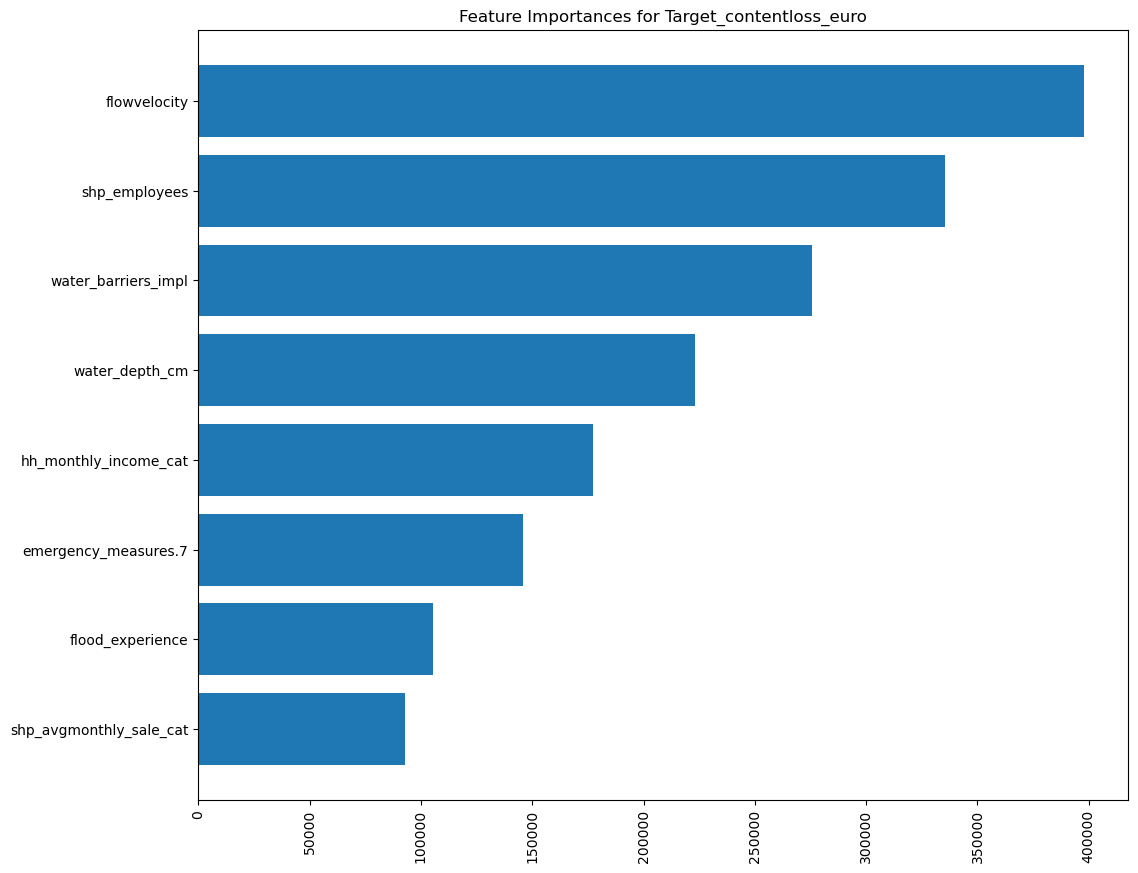

In [ ]:
fi_threshold = 20000
df_importance = df_importance.loc[df_importance.importances > 0.000, : ]      # drop features which dont reduce the loss
#df_importance = df_importance.loc[df_importance.importances > fi_threshold, : ]      # drop features which dont reduce the loss

df_importance = df_importance.sort_values("importances", ascending=True)
print("5 most important features:")
df_importance.shape

# plot feature importance
#fig, ax = plt.subplots(figsize=(12,10))
plt.figure(figsize=(8, 5))


# keep only features which reduce the loss
df_importance = df_importance.loc[df_importance.importances > 0, : ]

sns.barplot(
    data=df_importance, 
    x="importances", y="name",
    width=0.4,
    color='steelblue',
    #errorbar="sd",
    errorbar=("pi", 50), 
    capsize=.1, errcolor=".5",
    linewidth=3, #edgecolor=".3", #facecolor=(0,0,0,0),
)
plt.ylabel("")
plt.xticks(
    rotation = 90
    )
plt.title(f"CRF (transform): Feature Importances for {target}")
plt.show()

plt.show()

In [77]:
### Save to disk

In [78]:
##Feature selection
selected_feat = df_importance.T.columns

## write selected predictors to disk
fs.save_selected_features(X_train, pd.DataFrame(y_train), selected_feat, filename=f"../../input_survey_data/fs_crf_{target}.xlsx")


KeyError: "None of [Index([24, 4, 20, 8, 27, 19, 9, 23, 1, 13, 26, 3], dtype='int64')] are in the [columns]"

#### Statistics related to CIT and CRF

The log rather than the p-value is used because it is numerically much more stable when used for comparisons, computing the minimal value, etc. Note that the p-values can become extremely small when significant. 


statistic DEF: 

citrerion DEF: 



In [ ]:
# ## get signifcant features
# selected_feat = cit_stats.loc[:, cit_stats.loc["p_value",:]<= 0.05]


In [ ]:
## Snippet from: https://cran.r-project.org/web/packages/stablelearner/vignettes/forests.html
# cf_stablelearner = stablelearner.stabletree(cit_model,
#   sampler = stablelearner.subsampling, savetrees = True, B = 100, v = 0.632)
# #Internally, stablelearner::stabletree() does the following: For each of the 100 trees to be generated, the dataset is resampled according to the resampling method specified (in our case subsampling with a fraction of v = 0.632) and the function call of our initial tree (which we labeled ct_partykit) is updated with respect to this resampled data and reevaluated, resulting in a new tree. All the 100 trees together then build the forest.

# #2.2 Gaining insight into the forest
# #The following summary prints the variable selection frequency (freq) as well as the average number of splits in each variable (mean) over all 100 trees. As we do not want to focus on our initial tree (remember that we just grew a forest, where all trees are of equal interest), we set original = FALSE, as already mentioned in the introduction:
# t = base.summary(cf_stablelearner, original = False)

# ## Variable selection overview:
# ## Note: n python we can see the R df.index which contains the variable names, therefore it is not very usefull
# #pd.DataFrame(t).iloc[3,:][0] # frequency
# #pd.DataFrame(t).iloc[3,:][1] # mean
# #print(X.columns[:23])

In [ ]:
# ## actual p-values (without log)
# strucchange = importr("strucchange")
# strucchange.sctest(cit_model, node = 1)[1]  # p values

In [ ]:
cit_model_p.rx(3)

In [ ]:
cit_model_p.names
cit_model_p = np.array(cit_model_p.rx(3))
cit_model_p